In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import os

#from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
# utils
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()
    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [13]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [4]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [5]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, stride = 1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [6]:
#my
class DeConvLayer(nn.Module):
    def __init__(self, size, padding=1, stride = 1, #pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(DeConvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], stride = stride, padding=padding))
        #if pool_layer is not None:
        #    layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
     
    def forward(self, x):
        return self.model(x)

In [7]:
#my
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], stride=3, padding=1, bn=batchnorm) #->16, 10, 10 -> 16,5,5
        self._conv2 = ConvLayer([16, 8, 3],stride=2, padding=1, bn=batchnorm, pool_layer = nn.MaxPool2d(2, stride=1))# ->8, 3, 3 ->8, 2, 2

            
        self._deconv1 = DeConvLayer([8, 16, 4], stride=1,padding = 0, bn=batchnorm) # 16, 5, 5
        self._deconv2 = DeConvLayer([16, 16, 5], stride=3, padding=1, bn=batchnorm ) # 16, 15, 15
        self._deconv3 = DeConvLayer([16, 1, 2],stride=2, padding=1, bn=batchnorm ) # 1, 28, 28
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        #x = self._conv3(x)
        return x
    
    def deconv(self, x):
        x = self._deconv1(x)
        x = self._deconv2(x)
        x = self._deconv3(x)
        return x

        
    def forward(self, x):
        x = self.conv(x)
        x = self.deconv(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.mse_loss(output, target, **kwargs)
        return self._loss

In [8]:
models = {'bn': Net(True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [9]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

In [11]:
avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
line = lambda i, l : '{}: '.format(i) + avg_lambda(l)

def test(models, loader, log=None):
    test_size = len(loader.sampler)
    test_loss = {k: 0. for k in models}
    #correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss

    for k in models:
        test_loss[k] /= (test_size*28*28)

        if log is not None:
            for k in models:
                log[k].append(test_loss[k])
            
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    print(report, test_loss[k], test_size)


In [32]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
        #my
        #print(data.size())
        #print(target.size())
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)
    
    if not os.path.exists('./cae_img'):
        os.mkdir('./cae_img')
    
    if epoch % 2 == 0:
        data, _ = next(iter(test_loader))
        pic = to_img(models['bn'](data))
        save_image(pic, './cae_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './conv_autoencoder.pth')

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 0.032435
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 0.030641
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 0.033244
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 0.035164
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 0.034059
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 0.032510
Test set:
bn: Loss: 0.0312
 0.031190083655532524 10000
Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.031670
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 0.033055
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 0.030860
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 0.031170
Train Epoch: 2 [40000/50000 (80%)]	Losses bn: 0.031982
Train Epoch: 2 [50000/50000 (100%)]	Losses bn: 0.029756
Test set:
bn: Loss: 0.0305
 0.030509133109267877 10000
Train Epoch: 3 [0/50000 (0%)]	Losses bn: 0.033559
Train Epoch: 3 [10000/50000 (20%)]	Losses bn: 0.031762
Train Epoch: 3 [20000/50000 (40%)]	Losses bn: 0.030762
Train Epoch: 3 [30000/50000 (60%)]	Losses bn: 0.031115
Train Epoch: 3 [40000/5

KeyboardInterrupt: 

### Some visual tests :)

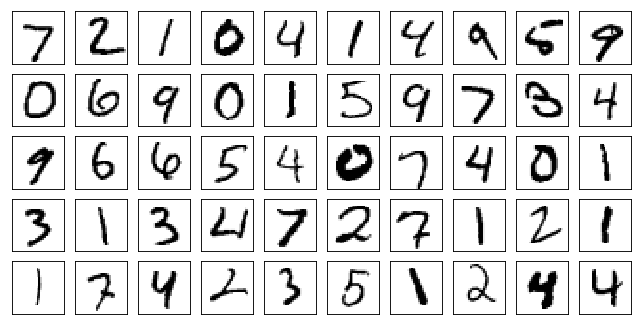

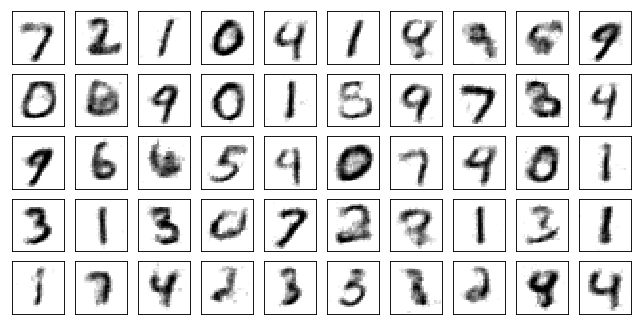

In [33]:
plot_mnist(data.data.numpy(), (5, 10))
output = models['bn'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (5, 10))

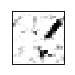

In [34]:
input_ex = torch.randn(1, 8, 2, 2, requires_grad=True)
hidden_l = models['bn'].deconv(input_ex)
hidden_l2 = hidden_l.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
#hidden_l3 = input_ex.view(-1, 1, 6, 6).clamp(0, 1).data.numpy()
#hidden_l.size()
to_plot = hidden_l2
plot_mnist(to_plot, (5, 10))
#plot_mnist(input_ex, (5,10))

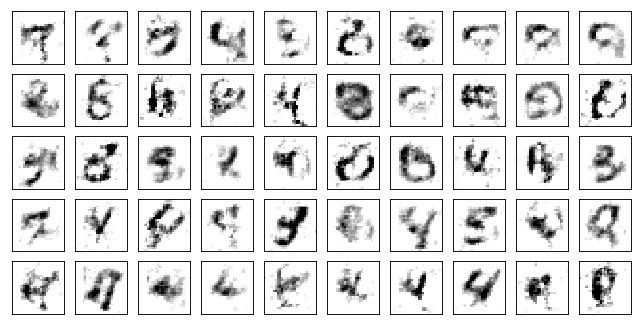

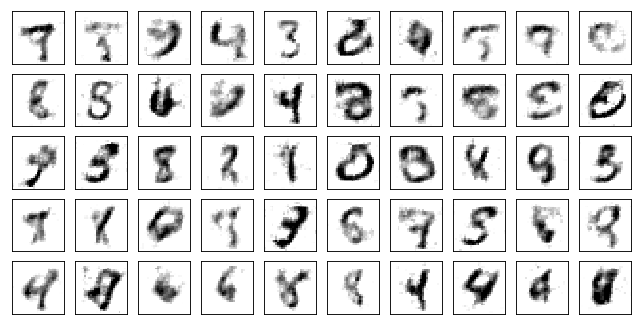

In [42]:
x = torch.randn(50, 1,28,28)
t = models['bn'](x)
plot_mnist(t.view(-1, 1, 28, 28).clamp(0, 1).data.numpy(), (5, 10))

output = models['bn'](t)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (5, 10))